In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score

In [15]:
# import the data
dataset = pd.read_parquet('../ourdata/static_dataset_session_798911424.parquet')
dataset

,stimulus_presentation_id,unit_id,orientation,spatial_frequency,spikes_per_second,area
0,49434,951088664,150.0,0.02,11.989965,APN
1,49434,951088679,150.0,0.02,7.993310,APN
2,49434,951088721,150.0,0.02,31.973239,APN
3,49434,951088823,150.0,0.02,3.996655,APN
4,49434,951088862,150.0,0.02,19.983275,APN
...,...,...,...,...,...,...
2660769,70389,951117252,0.0,0.16,3.996591,LP
2660770,70389,951117258,0.0,0.16,15.986363,LP
2660771,70389,951117264,0.0,0.16,7.993182,LP
2660772,70389,951117365,0.0,0.16,3.996591,CA1


We now take a look at the areas of the brain in our dataset:

In [16]:
# see the different areas of the brain in our dataset
dataset['area'].unique()

array(['APN', 'MB', 'NOT', 'DG', 'CA1', 'VISam', 'LP', 'ProS', 'SUB',
       'VISp', 'CA3', 'VISl', 'LGv', 'CA2', 'VISal', 'TH', 'Eth', 'VISrl'],
      dtype=object)

In [4]:
n_classes = len(dataset['area'].unique())

In [5]:
# dataset['area'] = dataset['area'].apply(lambda x: 
#     'Visual' if x in ['VISp', 'VISal', 'VISmma', 'VISrl', 'VISam', 'VISl'] else 
#     'Hippocampus' if x in ['CA1', 'CA2', 'CA3', 'DG', 'SUB', 'ProS'] else 
#     'Thalamus' if x in ['LP', 'LGd', 'POL', 'APN'] else 
#     'Other') 

In [17]:
# we drop the rows with nans
dataset = dataset.dropna()
print(dataset.shape[0])

2577804


In [18]:
# we filter for neurons that are spiking
dataset = dataset[dataset['spikes_per_second'] > 50]
dataset

,stimulus_presentation_id,unit_id,orientation,spatial_frequency,spikes_per_second,area
13,49434,951089174,150.0,0.02,79.933098,MB
22,49434,951089538,150.0,0.02,83.929753,NOT
72,49434,951093608,150.0,0.02,55.953169,VISam
103,49434,951096171,150.0,0.02,55.953169,DG
182,49434,951101983,150.0,0.02,107.909682,SUB
...,...,...,...,...,...,...
2660492,70389,951101525,0.0,0.16,59.948862,SUB
2660505,70389,951102034,0.0,0.16,51.955680,SUB
2660544,70389,951103632,0.0,0.16,51.955680,VISp
2660715,70389,951114629,0.0,0.16,63.945453,Eth


## Clustering

We now try to use two unsupervised algorithms to cluster the data (KMeans and DBSCAN)

In [8]:
dataset = dataset.sample(22000, random_state=42)

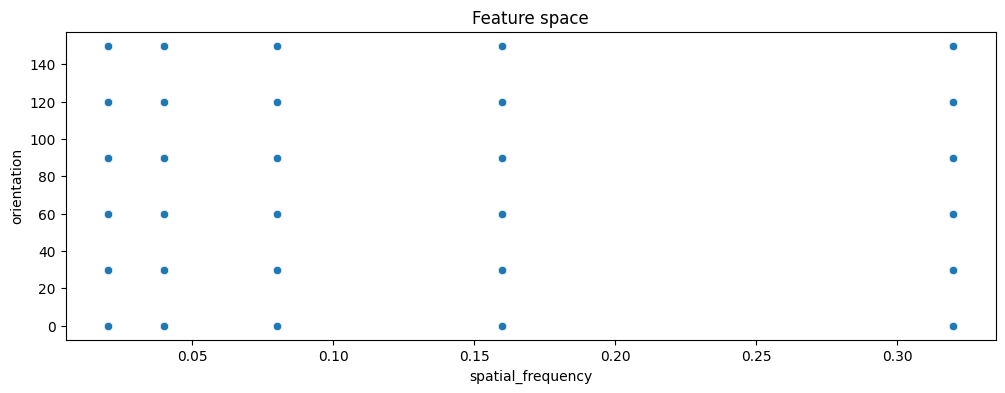

In [9]:
plt.figure(figsize=(12, 4))
sns.scatterplot(x=dataset['spatial_frequency'], y=dataset['orientation'])
plt.title('Feature space')
plt.show()

As the feature space has few elements and is rather regular, we do not expect unsupervised algorithms to work effectively

In [10]:
features = ['spatial_frequency', 'orientation']
X = dataset[features]
Y = dataset['area']  

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

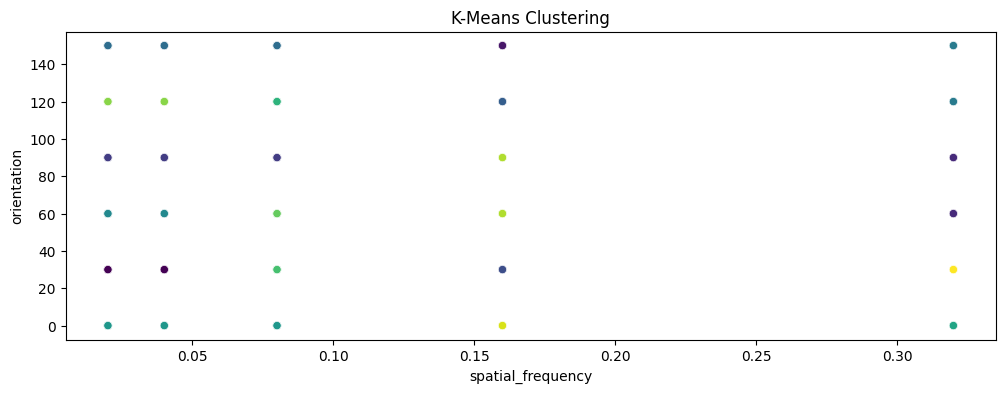

In [11]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_classes, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

dataset['KMeans_Cluster'] = kmeans_labels

# Visualize K-Means Clusters
plt.figure(figsize=(12, 4))
sns.scatterplot(x=dataset['spatial_frequency'], y=dataset['orientation'], hue=dataset['KMeans_Cluster'], palette='viridis', legend=False)
plt.title('K-Means Clustering')
plt.show()

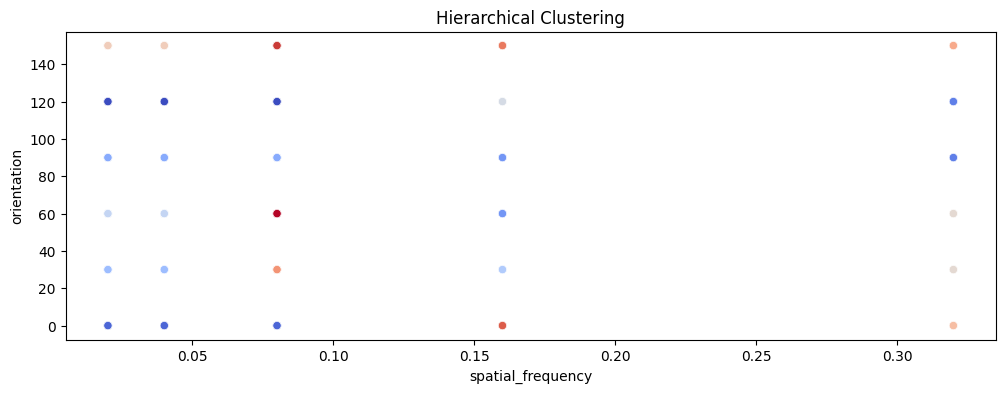

In [12]:
# Apply Hierarchical Clustering
agglo = AgglomerativeClustering(n_clusters=n_classes)
agglo_labels = agglo.fit_predict(X_scaled)
dataset['Hierarchical_Cluster'] = agglo_labels

# Visualize Hierarchical Clusters
plt.figure(figsize=(12, 4))
sns.scatterplot(x=dataset['spatial_frequency'], y=dataset['orientation'], hue=dataset['Hierarchical_Cluster'], palette='coolwarm', legend=False)
plt.title('Hierarchical Clustering')
plt.show()

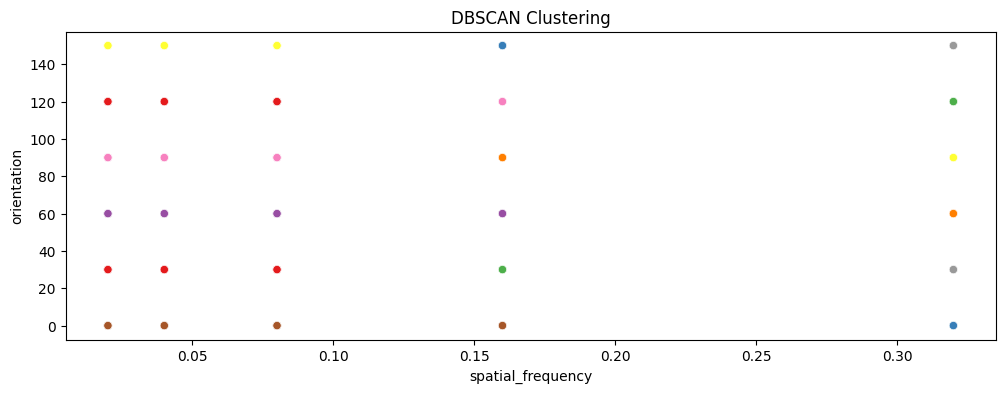

In [13]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
dataset['DBSCAN_Cluster'] = dbscan_labels

# Visualize DBSCAN Clusters
plt.figure(figsize=(12, 4))
sns.scatterplot(x=dataset['spatial_frequency'], y=dataset['orientation'], hue=dataset['DBSCAN_Cluster'], palette='Set1', legend=False)
plt.title('DBSCAN Clustering')
plt.show()

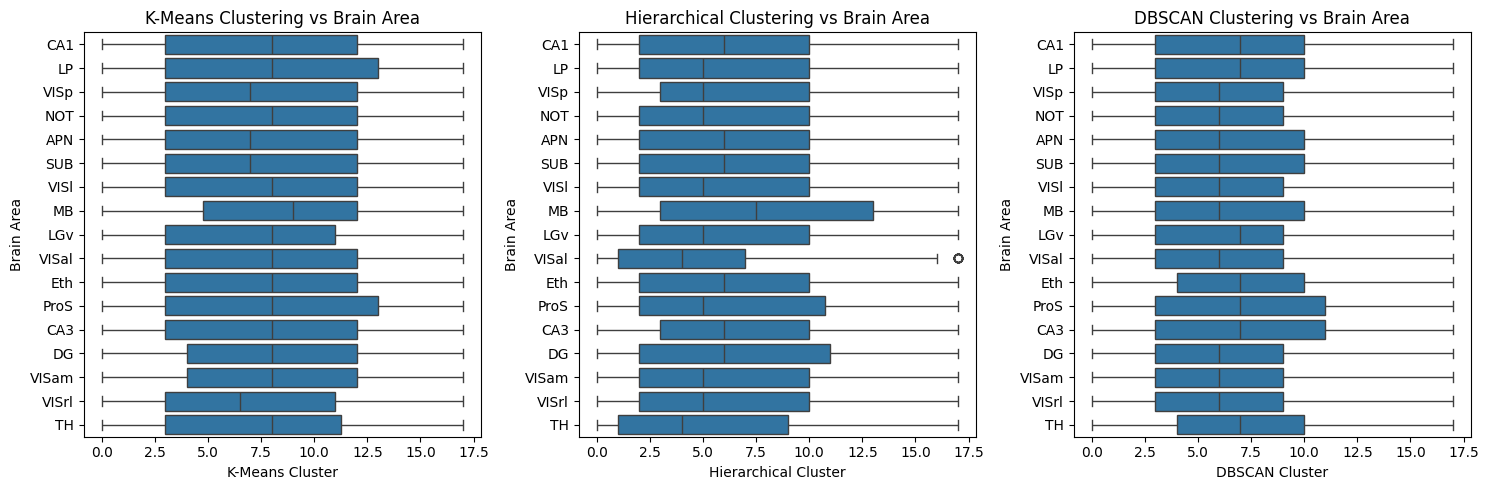

In [14]:
plt.figure(figsize=(15, 5))

# Plot for K-Means Clustering
plt.subplot(1, 3, 1)
sns.boxplot(x='KMeans_Cluster', y='area', data=dataset)
plt.title('K-Means Clustering vs Brain Area')
plt.xlabel('K-Means Cluster')
plt.ylabel('Brain Area')

# Plot for Hierarchical Clustering
plt.subplot(1, 3, 2)
sns.boxplot(x='Hierarchical_Cluster', y='area', data=dataset)
plt.title('Hierarchical Clustering vs Brain Area')
plt.xlabel('Hierarchical Cluster')
plt.ylabel('Brain Area')

# Plot for DBSCAN Clustering
plt.subplot(1, 3, 3)
sns.boxplot(x='DBSCAN_Cluster', y='area', data=dataset)
plt.title('DBSCAN Clustering vs Brain Area')
plt.xlabel('DBSCAN Cluster')
plt.ylabel('Brain Area')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

## Supervised classification: XGBoost

In [19]:
# Split data into training and testing sets
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=10)
xgb_model.fit(X_train, Y_train)

# Make predictions
Y_pred = xgb_model.predict(X_test)

/Users/edoardoghirardo/miniconda/envs/envallen/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/edoardoghirardo/miniconda/envs/envallen/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/edoardoghirardo/miniconda/envs/envallen/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       515
           1       0.23      1.00      0.38      1022
           2       0.00      0.00      0.00        55
           3       0.00      0.00      0.00        88
           4       0.00      0.00      0.00       174
           5       0.00      0.00      0.00       238
           6       0.00      0.00      0.00       330
           7       0.00      0.00      0.00       107
           8       0.00      0.00      0.00       393
           9       0.00      0.00      0.00        16
          10       0.00      0.00      0.00       466
          11       0.00      0.00      0.00        24
          12       0.00      0.00      0.00       192
          13       0.00      0.00      0.00       206
          14       0.00      0.00      0.00       162
          15       0.00      0.00      0.00       368
          16       0.00      0.00      0.00        44

   

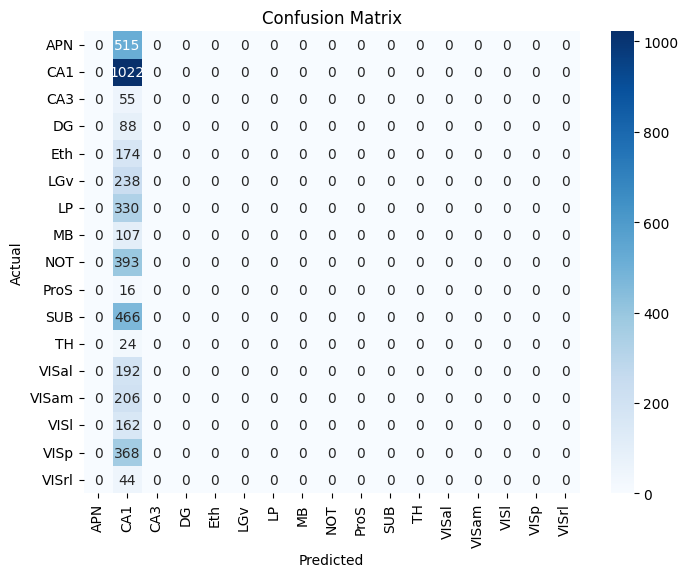

Accuracy: 0.2323


In [20]:
# Calculate accuracy
accuracy = accuracy_score(Y_test, Y_pred)

# Generate classification report
class_report = classification_report(Y_test, Y_pred)

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Display classification report
print("Classification Report:")
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print accuracy
print(f'Accuracy: {accuracy:.4f}')

# Compute ROC-AUC score if binary classification
if len(label_encoder.classes_) == 2:
    auc_score = roc_auc_score(Y_test, Y_pred)
    print(f'ROC-AUC Score: {auc_score:.4f}')

In [21]:
dataset

,stimulus_presentation_id,unit_id,orientation,spatial_frequency,spikes_per_second,area
13,49434,951089174,150.0,0.02,79.933098,MB
22,49434,951089538,150.0,0.02,83.929753,NOT
72,49434,951093608,150.0,0.02,55.953169,VISam
103,49434,951096171,150.0,0.02,55.953169,DG
182,49434,951101983,150.0,0.02,107.909682,SUB
...,...,...,...,...,...,...
2660492,70389,951101525,0.0,0.16,59.948862,SUB
2660505,70389,951102034,0.0,0.16,51.955680,SUB
2660544,70389,951103632,0.0,0.16,51.955680,VISp
2660715,70389,951114629,0.0,0.16,63.945453,Eth


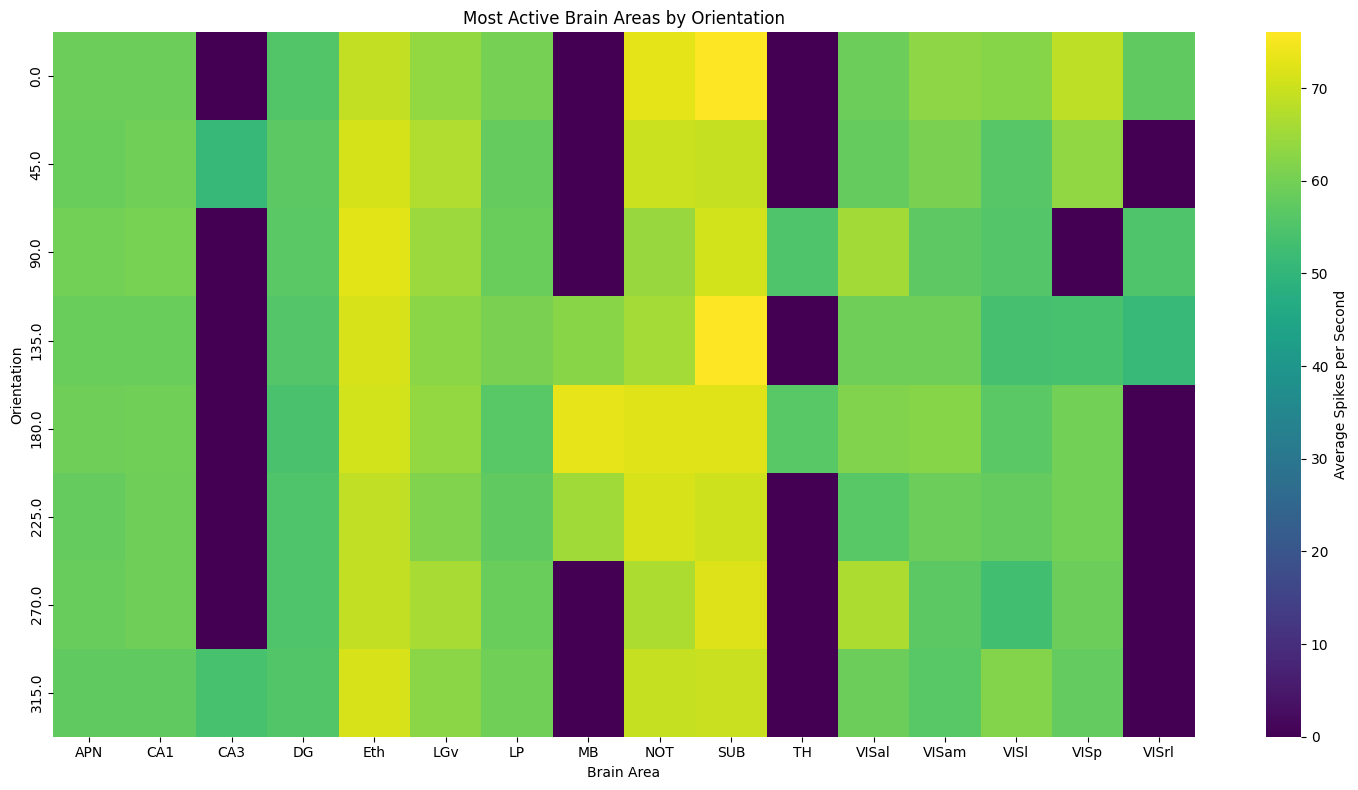

In [ ]:
# Group by orientation and calculate the average spikes_per_second for each area
grouped_orientation = dataset.groupby(['orientation', 'area'])['spikes_per_second'].mean().reset_index()

# Pivot the data for easier visualization
pivot_orientation = grouped_orientation.pivot_table(index='orientation', columns='area', values='spikes_per_second', fill_value=0)

# Plot the heatmap for orientation
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_orientation, cmap='viridis', annot=False, cbar_kws={'label': 'Average Spikes per Second'})
plt.title('Most Active Brain Areas by Orientation')
plt.xlabel('Brain Area')
plt.ylabel('Orientation')
plt.tight_layout()
plt.show()

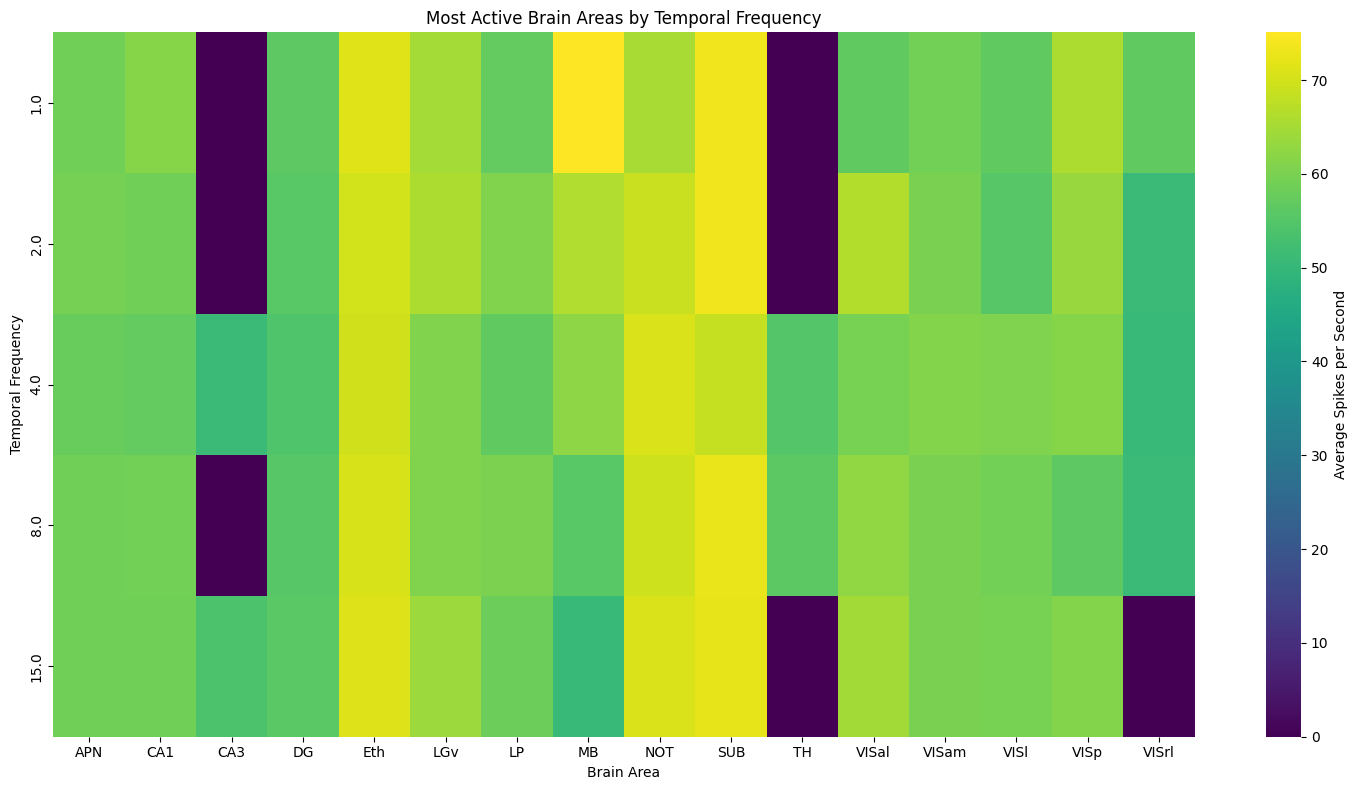

In [ ]:
# Group by spatial_frequency and calculate the average spikes_per_second for each area
grouped_frequency = dataset.groupby(['spatial_frequency', 'area'])['spikes_per_second'].mean().reset_index()

# Pivot the data for easier visualization
pivot_frequency = grouped_frequency.pivot_table(index='spatial_frequency', columns='area', values='spikes_per_second', fill_value=0)

# Plot the heatmap for temporal frequency
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_frequency, cmap='viridis', annot=False, cbar_kws={'label': 'Average Spikes per Second'})
plt.title('Most Active Brain Areas by Temporal Frequency')
plt.xlabel('Brain Area')
plt.ylabel('Temporal Frequency')
plt.tight_layout()
plt.show()